# Loading libraries

In [2]:
from typing import List, Union, Dict
import sys
import os
import yaml
import warnings
sys.path.insert(1, '..')
os.chdir('..')

import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sklearn
import optuna
import darts

from darts import models
from darts import metrics
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler

from statsforecast.models import AutoARIMA

from data_formatter.base import *
from bin.utils import *

# Processing raw data and adding covariates

In [ ]:
# load glucose data
df = pd.read_csv('raw_data/Weinstock2016_allfiles/Data Tables/BDataCGM.txt', sep='|')
# create Pandas start date and add days from DeviceDaysFromEnroll column
for id, data in df.groupby('PtID'):
    dates = pd.to_datetime('1900-01-01') + pd.to_timedelta(data['DeviceDaysFromEnroll'], unit='d')
    df.loc[data.index, 'Date'] = dates
# drop rows where glucose is NA
df.dropna(inplace=True, subset='Glucose')
# create full time column
df['time'] =pd.to_datetime(df['Date'].astype(str) + ' ' + df['DeviceTm'])
# rename Glucose column to gl and PtID to id
df.rename(columns={'Glucose': 'gl', 'PtID': 'id'}, inplace=True)
# drop all columns except id, time, and gl
df.drop(columns=[col for col in df.columns if col not in ['gl', 'time', 'id']], inplace=True)
# reset index
df.reset_index(drop=True, inplace=True)

In [ ]:
# load demographics data
df_demo = pd.read_csv('raw_data/Weinstock2016_allfiles/Data Tables/BDemoLifeDiabHxMgmt.txt', sep='|')
select_cols = ['PtID']
# select gender
select_cols.append('Gender')
# select race
select_cols.append('Race')
# select Education Level
select_cols.append('EduLevel')
df_demo['EduLevel'].fillna('Unknown', inplace=True) # replace NaN with 'Unknown'
# convert to numeric based on the mapping 
# 'Unknown' = 0,
# '7th or 8th Grade' = 1, 
# '9th Grade' = 2,
# '11th Grade' = 3, 
# '12th Grade - no diploma' = 4,
# 'High school graduate/diploma/GED' = 5,
# # 'Some college but no degree' = 6, 
# 'Associate Degree' = 7,
# # 'Professional Degree' = 8,  
# 'Bachelor's Degree' = 9, 
# 'Master's Degree' = 10, 
# 'Doctorate Degree' = 11,
df_demo['EduLevel'] = df_demo['EduLevel'].map({'Unknown': 0, 
                                               '7th or 8th Grade': 1, 
                                               '9th Grade': 2, 
                                               '11th Grade': 3, 
                                               '12th Grade - no diploma': 4, 
                                               'High school graduate/diploma/GED': 5, 
                                               'Some college but no degree': 6, 
                                               'Associate Degree': 7, 
                                               'Professional Degree': 8, 
                                               "Bachelor's Degree": 9, 
                                               "Master's Degree": 10, 
                                               "Doctorate Degree": 11})
# select AnnualInc
select_cols.append('AnnualInc')
df_demo['AnnualInc'].fillna('Unknown', inplace=True) # replace NaN with 'Unknown'
# convert to numeric based on the mapping
# 'Unknown' = 0,
# 'Less than $25,000' = 1,
# '$25,000 - $35,000' = 2, 
# '$35,000 - less than $50,000' = 3,
# '$50,000 - less than $75,000' = 4,
# '$75,000 - less than $100,000' = 5,
# '$100,000 - less than $200,000' = 6
# '$200,000 or more' = 7
df_demo['AnnualInc'] = df_demo['AnnualInc'].map({'Unknown': 0,
                                                 'Less than $25,000': 1,
                                                 '$25,000 - $35,000': 2,
                                                 '$35,000 - less than $50,000': 3,
                                                 '$50,000 - less than $75,000': 4,
                                                 '$75,000 - less than $100,000': 5,
                                                 '$100,000 - less than $200,000': 6,
                                                 '$200,000 or more': 7})

# select MaritalStatus
select_cols.append('MaritalStatus')
df_demo['MaritalStatus'].fillna('Unknown', inplace=True) # replace NaN with 'Unknown'
# select DaysWkEx
select_cols.append('DaysWkEx')
df_demo['DaysWkEx'].fillna(0, inplace=True) # replace NaN with 0
# select DaysWkDrinkAlc
select_cols.append('DaysWkDrinkAlc')
df_demo['DaysWkDrinkAlc'].fillna(0, inplace=True) # replace NaN with 0
# select DaysMonBingeAlc
select_cols.append('DaysMonBingeAlc')
df_demo['DaysMonBingeAlc'].fillna(0, inplace=True) # replace NaN with 0
# select T1DDiagAge
select_cols.append('T1DDiagAge')
# select NumHospDKA
select_cols.append('NumHospDKA')
df_demo['NumHospDKA'].fillna(0, inplace=True) # replace NaN with 0
# select NumSHSinceT1DDiag
select_cols.append('NumSHSinceT1DDiag')
# convert to numeric based on the mapping
# '0' = 0, 
# '1' = 1
# '2' = 2, 
# '3' = 3, 
# '4' = 4,
# '5 - 9' = 5,
# '10 - 19' = 6, 
# '>19' = 7
df_demo['NumSHSinceT1DDiag'] = df_demo['NumSHSinceT1DDiag'].map({'0': 0,
                                                                '1': 1,
                                                                '2': 2,
                                                                '3': 3,
                                                                '4': 4,
                                                                '5 - 9': 5,
                                                                '10 - 19': 6,
                                                                '>19': 7})
# select InsDeliveryMethod
select_cols.append('InsDeliveryMethod')
# select UnitsInsTotal, replace NaN with 0
select_cols.append('UnitsInsTotal')
df_demo['UnitsInsTotal'].fillna(0, inplace=True)
# select NumMeterCheckDay
select_cols.append('NumMeterCheckDay')
# convert to numeric based on the mapping
# '0' = 0,
# '1' = 1,
# '2' = 2,
# '3' = 3,
# '4' = 4,
# '5' = 5,
# '6' = 6,
# '7' = 7,
# '8' = 8,
# '9' = 9,
# '10' = 10,
# '11' = 11,
# '12' = 12,
# '13' = 13,
# '14' = 14,
# '15' = 15,
# '16' = 16,
# '17' = 17,
# '18' = 18,
# '> 19' = 19
df_demo['NumMeterCheckDay'] = df_demo['NumMeterCheckDay'].map({'0': 0,
                                                                '1': 1,
                                                                '2': 2,
                                                                '3': 3,
                                                                '4': 4,
                                                                '5': 5,
                                                                '6': 6,
                                                                '7': 7,
                                                                '8': 8,
                                                                '9': 9,
                                                                '10': 10,
                                                                '11': 11,
                                                                '12': 12,
                                                                '13': 13,
                                                                '14': 14,
                                                                '15': 15,
                                                                '16': 16,
                                                                '17': 17,
                                                                '18': 18,
                                                                '> 19': 19})
# leave only selected columns
df_demo = df_demo[select_cols]
# rename PtID to id
df_demo.rename(columns={'PtID': 'id'}, inplace=True)
# print selected columns
print(df_demo.columns)

In [ ]:
# load medical conditions data
df_medchart = pd.read_csv('./raw_data/Weinstock2016_allfiles/Data Tables/BMedChart.txt', sep='|')
# convert weight to lbs
df_medchart.loc[df_medchart['WeightUnits'] == 'kg', 'Weight'] = df_medchart.loc[df_medchart['WeightUnits'] == 'kg', 'Weight'] * 2.20462
# convert height to inches
df_medchart.loc[df_medchart['HeightUnits'] == 'cm', 'Height'] = df_medchart.loc[df_medchart['HeightUnits'] == 'cm', 'Height'] * 0.393701
# select Height and Weight and fill NaN with 0
df_medchart['Height'].fillna(0, inplace=True)
df_medchart['Weight'].fillna(0, inplace=True)
df_medchart = df_medchart[['PtID', 'Height', 'Weight']]
# rename PtID to id
df_medchart.rename(columns={'PtID': 'id'}, inplace=True)
# print selected columns
print(df_medchart.columns)


In [ ]:
# load medical conditions data
df_medcond = pd.read_csv('./raw_data/Weinstock2016_allfiles/Data Tables/BMedicalConditions.txt', sep='|')
# select top-13 illnesses (>10% of 201 patients have at least one of them based on value counts)
top13_illnesses = df_medcond['MCLLTReal'].value_counts().index[:13]
# create a one-hot encoding of the top-13 illnesses
df_medcond = pd.get_dummies(df_medcond, columns=['MCLLTReal'], prefix='', prefix_sep='', dummy_na=True)
df_medcond = df_medcond[['PtID'] + top13_illnesses.tolist()]
# remove zero rows
df_medcond = df_medcond.loc[(df_medcond[top13_illnesses] != 0).any(axis=1)]
# rename PtID to id
df_medcond.rename(columns={'PtID': 'id'}, inplace=True)
# sum rows for the same id
df_medcond = df_medcond.groupby('id').sum()
# reset index
df_medcond.reset_index(inplace=True)
# print top-13 illnesses
print(top13_illnesses)


In [ ]:
# load medication data
df_med = pd.read_csv('./raw_data/Weinstock2016_allfiles/Data Tables/BMedication.txt', sep='|')
# select top-9 medications (>10% of 201 patients have at least one of them based on value counts)
all_meds = df_med['DrugName'].unique()
top9_meds = df_med['DrugName'].value_counts().index[:9]
# create a one-hot encoding of the top-9 medications
df_med = pd.get_dummies(df_med, columns=['DrugName'], prefix='', prefix_sep='', dummy_na=True)

# strip first number from MedDose
import re
def strip_first_number(x):
    x = str(x)
    # remove all ,
    x = x.replace(',', '')
    # find first non-number and not . or , character in string x
    first_non_num = re.search(r'[^0-9.]', x)
    if first_non_num is None:
        return float(x)
    else:
        return float(x[:first_non_num.start()]) if first_non_num.start() > 0 else 1.0
# apply strip_first_number to MedDose per element
df_med['MedDose'].fillna(1, inplace=True)
for i in range(len(df_med)):
    df_med['MedDose'].iloc[i] = strip_first_number(df_med['MedDose'].iloc[i])

# for each patient get the dose for each medication
df_med[all_meds].values[df_med[all_meds] != 0] = df_med['MedDose']
# select PtID and top-9 medications
df_med = df_med[['PtID'] + top9_meds.tolist()]
# remove zero rows
df_med = df_med.loc[(df_med[top9_meds] != 0).any(axis=1)]
# rename PtID to id
df_med.rename(columns={'PtID': 'id'}, inplace=True)
# sum rows for the same id
df_med = df_med.groupby('id').sum()
# reset index
df_med.reset_index(inplace=True)
# print top-9 medications
print(top9_meds)

In [ ]:
# merge all dataframes
df_new = df.merge(df_demo, on = 'id', how='left')
df_new = df_new.merge(df_medchart, on = 'id', how='left')
df_new = df_new.merge(df_medcond, on = 'id', how='left')
df_new = df_new.merge(df_med, on = 'id', how='left')

In [ ]:
# fill na values with zeros for df_med and df_medcond columns
df_new[top13_illnesses] = df_new[top13_illnesses].fillna(0)
df_new[top9_meds] = df_new[top9_meds].fillna(0)

In [ ]:
# save as Weinstock2016_processed.csv
df_new.to_csv('./raw_data/Weinstock2016_processed_with_covariates.csv', index=False)

# Check statistics of the data

In [ ]:
# load yaml config file
with open('./config/weinstock.yaml', 'r') as f:
    config = yaml.safe_load(f)

# set interpolation params for no interpolation
new_config = config.copy()
new_config['interpolation_params']['gap_threshold'] = 5
new_config['interpolation_params']['min_drop_length'] = 0
# set split params for no splitting
new_config['split_params']['test_percent_subjects'] = 0
new_config['split_params']['length_segment'] = 0
# set scaling params for no scaling
new_config['scaling_params']['scaler'] = 'None'

formatter = DataFormatter(new_config)

In [ ]:
# print min, max, median, mean, std of segment lengths
segment_lens = []
for group, data in formatter.train_data.groupby('id_segment'):
    segment_lens.append(len(data))
print('Train segment lengths:')
print('\tMin: ', min(segment_lens))
print('\tMax: ', max(segment_lens))
print('\t1st Quartile: ', np.quantile(segment_lens, 0.25))
print('\tMedian: ', np.median(segment_lens))
print('\tMean: ', np.mean(segment_lens))
print('\tStd: ', np.std(segment_lens))

# plot first 9 segments
num_segments = 9
plot_data = formatter.train_data

fig, axs = plt.subplots(1, num_segments, figsize=(30, 5))
for i, (group, data) in enumerate(plot_data.groupby('id_segment')):
    data.plot(x='time', y='gl', ax=axs[i], title='Segment {}'.format(group))
    if i >= num_segments - 1:
        break

In [ ]:
# plot acf of random samples from first 9 segments segments
fig, ax = plt.subplots(2, num_segments, figsize=(30, 5))
lags = 300; k = 0
for i, (group, data) in enumerate(plot_data.groupby('id_segment')):
    data = data['gl']
    if len(data) < lags:
        print('Segment {} is too short'.format(group))
        continue
    else:
        # select 10 random samples from index of data
        sample = np.random.choice(range(len(data))[:-lags], 10, replace=False)
        # plot acf / pacf of each sample
        for j in sample:
            acf, acf_ci = sm.tsa.stattools.acf(data[j:j+lags], nlags=lags, alpha=0.05)
            pacf, pacf_ci = sm.tsa.stattools.pacf(data[j:j+lags], method='ols-adjusted', alpha=0.05)
            ax[0, k].plot(acf)
            ax[1, k].plot(pacf)
        k += 1
        if k >= num_segments:
            break

ACF plots suggest that significant dependency persists up to 200 points (~16 hours). The analysis of distribution of segment lengths suggests that there are too many short segments. 
Based on this, interpolation should be performed of missing values up to 45 minutes (9 points), segments less than 200 points should be dropped.

In [ ]:
# set interpolation params for interpolation
new_config['interpolation_params']['gap_threshold'] = 45 # minutes - use as in config file 
new_config['interpolation_params']['min_drop_length'] = 240

formatter = DataFormatter(new_config)

In [ ]:
# print min, max, median, mean, std of segment lengths
segment_lens = []
for group, data in formatter.train_data.groupby('id_segment'):
    segment_lens.append(len(data))
print('Train segment lengths:')
print('\tMin: ', min(segment_lens))
print('\tMax: ', max(segment_lens))
print('\t1st Quartile: ', np.quantile(segment_lens, 0.25))
print('\tMedian: ', np.median(segment_lens))
print('\t3rd Quartile: ', np.quantile(segment_lens, 0.75))
print('\tMean: ', np.mean(segment_lens))
print('\tStd: ', np.std(segment_lens))

# plot first 9 segments
num_segments = 9
plot_data = formatter.train_data

fig, axs = plt.subplots(1, num_segments, figsize=(30, 5))
for i, (group, data) in enumerate(plot_data.groupby('id_segment')):
    data.plot(x='time', y='gl', ax=axs[i], title='Segment {}'.format(group))
    if i >= num_segments - 1:
        break

In [ ]:
# plot acf of random samples from first 9 segments segments
fig, ax = plt.subplots(2, num_segments, figsize=(30, 5))
lags = 300; k = 0
for i, (group, data) in enumerate(plot_data.groupby('id_segment')):
    data = data['gl']
    if len(data) < lags:
        print('Segment {} is too short'.format(group))
        continue
    else:
        # select 10 random samples from index of data
        sample = np.random.choice(range(len(data))[:-lags], 10, replace=False)
        # plot acf / pacf of each sample
        for j in sample:
            acf, acf_ci = sm.tsa.stattools.acf(data[j:j+lags], nlags=lags, alpha=0.05)
            pacf, pacf_ci = sm.tsa.stattools.pacf(data[j:j+lags], method='ols-adjusted', alpha=0.05)
            ax[0, k].plot(acf)
            ax[1, k].plot(pacf)
        k += 1
        if k >= num_segments:
            break

It is very hard to name the proper parameters for ARIMA model based on current ACF and PACF plots since within each segment, samples are behaving very differently showing different structures suitable for ARIMA model. However, we can still spot some common traits between segments. First, the autocorrelation graphs decays exponentially for almost every segment, on average, up to 20-50 lags (in some cases up to 100). Hence, the Auto Regression (AR) parameter can be set around these numbers. The partial autocorrelation plots pick around 2 for the first time and become close to zero after 5 lags at max. So, the Moving Average (MA) parameter can be set at 2. 

# Change the config according to the observations above

In [ ]:
with open('./config/weinstock.yaml', 'r') as f:
    config = yaml.safe_load(f)
    
# set interpolation params for no interpolation
config['interpolation_params']['gap_threshold'] = 45
config['interpolation_params']['min_drop_length'] = 240
# set split params for no splitting
config['split_params']['test_percent_subjects'] = 0.1
config['split_params']['length_segment'] = 240
# set scaling params for no scaling
config['scaling_params']['scaler'] = 'None'

formatter = DataFormatter(config)

# Models (no covariates)

## Convert data and (optional) scaling

In [ ]:
def load_data(seed = 0, study_file = None):
    # load data
    with open('./config/weinstock.yaml', 'r') as f:
        config = yaml.safe_load(f)
    config['split_params']['random_state'] = seed
    formatter = DataFormatter(config, study_file = study_file)

    # convert to series
    time_col = formatter.get_column('time')
    group_col = formatter.get_column('sid')
    target_col = formatter.get_column('target')
    static_cols = formatter.get_column('static_covs')
    static_cols = static_cols + [formatter.get_column('id')] if static_cols is not None else [formatter.get_column('id')]
    dynamic_cols = formatter.get_column('dynamic_covs')
    future_cols = formatter.get_column('future_covs')

    # build series
    series, scalers = make_series({'train': formatter.train_data,
                                    'val': formatter.val_data,
                                    'test': formatter.test_data.loc[~formatter.test_data.index.isin(formatter.test_idx_ood)],
                                    'test_ood': formatter.test_data.loc[formatter.test_data.index.isin(formatter.test_idx_ood)]},
                                    time_col,
                                    group_col,
                                    {'target': target_col,
                                    'static': static_cols,
                                    'dynamic': dynamic_cols,
                                    'future': future_cols})
    
    return formatter, series, scalers

formatter, series, scalers = load_data()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
hours = []
for i in range(len(series['test']['target'])):
    hours += list(series['test']['target'][i].time_index[formatter.params['max_length_input']: ].hour)
axs[0].hist(hours, bins=36)

hours = []
for i in range(len(series['test_ood']['target'])):
    hours += list(series['test_ood']['target'][i].time_index[formatter.params['max_length_input']: ].hour)
axs[1].hist(hours, bins=36)

In [ ]:
for f in series['train']['target']:
    f.plot(label='train', alpha=0.1, color='grey')
series['test_ood']['target'][0].plot(label='test_ood')
for f in series['test']['target']:
    f.plot(label='test_id', color='orange', alpha=0.5)

In [ ]:
# plot 18h segments that start at 6AM
fig, axs = plt.subplots(3, 3, figsize=(15, 10))
for i in range(3):
    for j in range(3):
        serie = series['train']['target'][i+3*j]
        start = None
        for k, hour in enumerate(serie.time_index.hour):
            if hour == 6:
                start = k
                break
        if start is not None and start + 216 <= len(serie):
            serie = serie[start:(start+216)]
            serie.plot(ax=axs[i, j], label='Segment {}'.format(i+3*j))

In [ ]:
# plot 18h segments that start at 6AM
fig, axs = plt.subplots(3, 3, figsize=(15, 10))
for i in range(3):
    for j in range(3):
        serie = series['train']['target'][i+3*j]
        start = None
        for k, hour in enumerate(serie.time_index.hour):
            if hour == 6:
                start = k
                break
        if start is not None and start + 216 <= len(serie):
            serie = serie[start:(start+216)]
            # rescale
            serie = scalers['target'].inverse_transform(serie)
            # set y-axis limits for axs[i, j]
            serie.plot(ax=axs[i, j], label='Segment {}'.format(i+3*j))
            axs[i, j].set_ylim(0, 420)

## ARIMA

In [ ]:
def test_model(test_data, scaler, in_len, out_len, stride, target_col, group_col):
    errors = []
    for group, data in test_data.groupby(group_col):
        train_set = data[target_col].iloc[:in_len].values.flatten()
        # fit model
        model = AutoARIMA(start_p = 0,
                        max_p = 10,
                        start_q = 0,
                        max_q = 10,
                        start_P = 0,
                        max_P = 10,
                        start_Q=0,
                        max_Q=10,
                        allowdrift=True,
                        allowmean=True,
                        parallel=False)
        model.fit(train_set)
        # get valid sampling locations for future prediction
        start_idx = np.arange(start=stride, stop=len(data) - in_len - out_len + 1, step=stride)
        end_idx = start_idx + in_len
        # iterate and collect predictions
        for i in range(len(start_idx)):
            input = data[target_col].iloc[start_idx[i]:end_idx[i]].values.flatten()
            true = data[target_col].iloc[end_idx[i]:(end_idx[i]+out_len)].values.flatten()
            prediction = model.forward(input, h=out_len)['mean']
            # unscale true and prediction
            true = scaler.inverse_transform(true.reshape(-1, 1)).flatten()
            prediction = scaler.inverse_transform(prediction.reshape(-1, 1)).flatten()
            # collect errors
            errors.append(np.array([np.mean((true - prediction)**2), np.mean(np.abs(true - prediction))]))
    errors = np.vstack(errors)
    return errors

In [ ]:
# load data
with open('./config/iglu.yaml', 'r') as f:
        config = yaml.safe_load(f)
config['split_params']['random_state'] = 0
config['scaling_params']['scaler'] = 'StandardScaler'
formatter = DataFormatter(config, study_file = None)

# set params
in_len = formatter.params['max_length_input']
out_len = formatter.params['length_pred']
stride = formatter.params['length_pred'] // 2
target_col = formatter.get_column('target')
group_col = formatter.get_column('sid')

In [ ]:
test_data = formatter.test_data.loc[~formatter.test_data.index.isin(formatter.test_idx_ood)]
test_data_ood = formatter.test_data.loc[formatter.test_data.index.isin(formatter.test_idx_ood)]

# backtest on the ID test set
id_errors_sample = test_model(test_data, formatter.scalers[target_col[0]], in_len, out_len, stride, target_col, group_col)
id_errors_sample = np.vstack(id_errors_sample)
id_error_stats_sample = compute_error_statistics(id_errors_sample)

# backtest on the ood test set
ood_errors_sample = test_model(test_data_ood, formatter.scalers[target_col[0]], in_len, out_len, stride, target_col, group_col)
ood_errors_sample = np.vstack(ood_errors_sample)
ood_errors_stats_sample = compute_error_statistics(ood_errors_sample)

## Linear regression

In [ ]:
model = models.LinearRegressionModel(lags = 60,
                                     output_chunk_length = formatter.params['length_pred'])

model.fit(series['train']['target'],
          max_samples_per_ts=None, 
          )

In [ ]:
forecasts = model.historical_forecasts(series['test']['target'],
                                        forecast_horizon=formatter.params['length_pred'], 
                                        stride=formatter.params['length_pred'] // 2,
                                        retrain=False,
                                        verbose=True,
                                        last_points_only=False,
                                        start=formatter.params['max_length_input'])
id_errors_sample = rescale_and_backtest(series['test']['target'],
                                    forecasts,  
                                    [metrics.mse, metrics.mae],
                                    scalers['target'],
                                    reduction=None)
id_errors_sample = np.vstack(id_errors_sample)
np.median(id_errors_sample, axis=0)

In [ ]:
forecasts = model.historical_forecasts(series['test_ood']['target'],
                                                forecast_horizon=formatter.params['length_pred'], 
                                                stride=formatter.params['length_pred'] // 2,
                                                retrain=False,
                                                verbose=True,
                                                last_points_only=False,
                                                start=formatter.params["max_length_input"])
ood_errors_sample = rescale_and_backtest(series['test_ood']['target'],
                            forecasts,  
                            [metrics.mse, metrics.mae],
                            scalers['target'],
                            reduction=None)
ood_errors_sample = np.vstack(ood_errors_sample)
np.median(ood_errors_sample, axis=0)

In [ ]:
fig, axs = plt.subplots(5, 6, figsize=(50, 20))
for i in range(6):
    for j, f in enumerate(forecasts[i][:5]):
        f.plot(ax=axs[j, i], label='forecast')
        series['val']['target'][i].slice_n_points_after(f.time_index[0] - pd.Timedelta("2h"), 36).plot(ax=axs[j, i], label='true')
        axs[j, i].legend(fontsize=14)

## XGBoost

In [ ]:
model = models.XGBModel(lags=96, 
                        learning_rate=0.773,
                        subsample=0.8,
                        min_child_weight=1.0,
                        colsample_bytree=1.0,
                        max_depth=6,
                        gamma=0.5,
                        reg_alpha=0.167,
                        reg_lambda=0.229,
                        n_estimators=352,
                        model_seed=0)

model.fit(series['train']['target'],
          max_samples_per_ts=None, 
          )

In [ ]:
forecasts = model.historical_forecasts(series['test']['target'],
                                        forecast_horizon=formatter.params['length_pred'], 
                                        stride=formatter.params['length_pred'] // 2,
                                        retrain=False,
                                        verbose=True,
                                        last_points_only=False,
                                        start=formatter.params['max_length_input'])
id_errors_sample = rescale_and_backtest(series['test']['target'],
                                    forecasts,  
                                    [metrics.mse, metrics.mae],
                                    scalers['target'],
                                    reduction=None)
id_errors_sample = np.vstack(id_errors_sample)
np.median(id_errors_sample, axis=0)

In [ ]:
forecasts = model.historical_forecasts(series['test_ood']['target'],
                                                forecast_horizon=formatter.params['length_pred'], 
                                                stride=formatter.params['length_pred'] // 2,
                                                retrain=False,
                                                verbose=True,
                                                last_points_only=False,
                                                start=formatter.params["max_length_input"])
ood_errors_sample = rescale_and_backtest(series['test_ood']['target'],
                            forecasts,  
                            [metrics.mse, metrics.mae],
                            scalers['target'],
                            reduction=None)
ood_errors_sample = np.vstack(ood_errors_sample)
np.median(ood_errors_sample, axis=0)

In [ ]:
def rescale_and_backtest(series: Union[TimeSeries, Sequence[TimeSeries]],
                         forecasts: Union[TimeSeries, Sequence[TimeSeries]], 
                         metric: Union[
                                    Callable[[TimeSeries, TimeSeries], float],
                                    List[Callable[[TimeSeries, TimeSeries], float]],
                                ], 
                         scaler: Callable[[TimeSeries], TimeSeries] = None,
                         reduction: Union[Callable[[np.ndarray], float], None] = np.mean,
                        ):
    """
    Backtest the forecasts on the series.

    Parameters
    ----------
    series
        The target time series.
    forecasts
        The forecasts.
    scaler
        The scaler used to scale the series.
    metric
        The metric to use for backtesting.
    reduction
        The reduction to apply to the metric.

    Returns
    -------
    float or List[float] or List[List[float]]
        The (sequence of) error score on a series, or list of list containing error scores for each
        provided series and each sample.
    """
    series = [series] if isinstance(series, TimeSeries) else series
    if len(series) == 1:
        forecasts = [forecasts]
    if not isinstance(metric, list):
        metric = [metric]

    # reverse scaling, forecasts and true values, compute errors
    backtest_list = []
    for idx, target_ts in enumerate(series):
        if scaler is not None:
            target_ts = scaler.inverse_transform(target_ts)
            predicted_ts = [scaler.inverse_transform(f) for f in forecasts[idx]]
        errors = [
            [metric_f(target_ts, f) for metric_f in metric]
            if len(metric) > 1
            else metric[0](target_ts, f)
            for f in predicted_ts
            if f.time_index.hour[0] > 6 and f.time_index.hour[0] < 18
        ]
        if reduction is None:
            backtest_list.append(np.array(errors))
        else:
            backtest_list.append(reduction(np.array(errors), axis=0))
    return backtest_list if len(backtest_list) > 1 else backtest_list[0]

ood_errors_sample = rescale_and_backtest(series['test_ood']['target'],
                            forecasts,  
                            [metrics.mse, metrics.mae],
                            scalers['target'],
                            reduction=None)
ood_errors_sample = np.vstack(ood_errors_sample)
np.median(ood_errors_sample, axis=0)

In [ ]:
fig, axs = plt.subplots(5, 6, figsize=(50, 20))
for i in range(6):
    for j, f in enumerate(forecasts[i][:5]):
        true = scalers['target'].inverse_transform(series['test']['target'][i].slice_n_points_after(f.time_index[0] - pd.Timedelta("2h"), 36))
        forecast = scalers['target'].inverse_transform(f)
        forecast.plot(ax=axs[j, i], label='forecast')
        true.plot(ax=axs[j, i], label='true')
        axs[j, i].legend(fontsize=14)

In [ ]:
fig, axs = plt.subplots(5, 6, figsize=(50, 20))
for i in range(6):
    for j in range(5):
        forecast = scalers['target'].inverse_transform(forecasts[i+6*j])
        true = scalers['target'].inverse_transform(series['test_ood']['target'][0].slice_n_points_after(forecast.time_index[0] - pd.Timedelta("2h"), 36))
        forecast.plot(ax=axs[j, i], label='forecast')
        true.plot(ax=axs[j, i], label='true')

## TFT

In [ ]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

model_name = f'tensorboard_tft_weinstock'
work_dir = './output'
el_stopper = EarlyStopping(
                            monitor="val_loss",
                            patience=20,
                            min_delta=0.001,
                            mode='min',
                            )
loss_logger = LossLogger()
pl_trainer_kwargs = {"accelerator": "gpu", "devices": [0], "callbacks": [el_stopper, loss_logger]}

# build the TFTModel model
model = models.TFTModel(input_chunk_length = 96, 
                        output_chunk_length = formatter.params['length_pred'], 
                        hidden_size = 64,
                        lstm_layers = 1,
                        num_attention_heads = 4,
                        full_attention = True,
                        dropout = 0.1,
                        hidden_continuous_size = 16,
                        add_relative_index = True,
                        model_name = model_name,
                        work_dir = work_dir,
                        log_tensorboard = True,
                        pl_trainer_kwargs = pl_trainer_kwargs,
                        batch_size = 64,
                        optimizer_kwargs = {'lr': 0.001},
                        save_checkpoints = True,
                        force_reset=True)

In [ ]:
model.fit(series=series['train']['target'],
              val_series=series['val']['target'],
              max_samples_per_ts=200,
              verbose=True,)

In [ ]:
forecasts = model.historical_forecasts(series['test']['target'],
                                        forecast_horizon=formatter.params['length_pred'], 
                                        stride=formatter.params['length_pred'] // 2,
                                        retrain=False,
                                        verbose=False,
                                        last_points_only=False,
                                        start=formatter.params['max_length_input'])

In [ ]:
errors = rescale_and_backtest(series['test']['target'],
                                      forecasts,  
                                      [metrics.mse, metrics.mae],
                                      scalers['target'],
                                      reduction=None)
errors = np.vstack(errors)         
np.median(errors, axis=0)                             

In [ ]:
fig, axs = plt.subplots(5, 6, figsize=(50, 20))
for i in range(6):
    for j, f in enumerate(forecasts[i][:5]):
        f.plot(ax=axs[j, i], label='forecast')
        series['test']['target'][i].slice_n_points_after(f.time_index[0] - pd.Timedelta("2h"), 36).plot(ax=axs[j, i], label='true')
        axs[j, i].legend(fontsize=14)

## NHiTS

In [ ]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

model_name = f'tensorboard_nhits_weinstock'
work_dir = './output'
el_stopper = EarlyStopping(monitor="val_loss", patience=20, min_delta=0.001, mode='min')
loss_logger = LossLogger()
pl_trainer_kwargs = {"accelerator": "gpu", "devices": [0], "callbacks": [el_stopper, loss_logger]}

# build the TFTModel model
model = models.NHiTSModel(input_chunk_length=96, 
                            output_chunk_length=12, 
                            num_stacks=3, 
                            num_blocks=1, 
                            num_layers=2, 
                            layer_widths=512,  
                            n_freq_downsample=None, 
                            dropout=0.05, 
                            activation='ReLU',
                            log_tensorboard = True,
                            pl_trainer_kwargs = pl_trainer_kwargs,
                            batch_size = 64,
                            optimizer_kwargs = {'lr': 0.001},
                            save_checkpoints = True,
                            model_name = model_name,
                            work_dir = work_dir,
                            force_reset=True)

In [ ]:
model.fit(series=series['train']['target'],
              val_series=series['val']['target'],
              max_samples_per_ts=200,
              verbose=True,)

In [ ]:
model.load_from_checkpoint(model_name, work_dir = work_dir)

forecasts = model.historical_forecasts(series['test']['target'],
                                        forecast_horizon=formatter.params['length_pred'], 
                                        stride=formatter.params['length_pred'] // 2,
                                        retrain=False,
                                        verbose=False,
                                        last_points_only=False,
                                        start=formatter.params['max_length_input'])

errors = rescale_and_backtest(series['test']['target'],
                                      forecasts,  
                                      [metrics.mse, metrics.mae],
                                      scalers['target'],
                                      reduction=None)
errors = np.vstack(errors)         
np.median(errors, axis=0)                             

In [ ]:
fig, axs = plt.subplots(5, 6, figsize=(50, 20))
for i in range(6):
    for j, f in enumerate(forecasts[i][:5]):
        f.plot(ax=axs[j, i], label='forecast')
        series['test']['target'][i].slice_n_points_after(f.time_index[0] - pd.Timedelta("2h"), 36).plot(ax=axs[j, i], label='true')
        axs[j, i].legend(fontsize=14)

## Transformer

In [ ]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

model_name = f'tensorboard_transformer_weinstock'
work_dir = './output'
el_stopper = EarlyStopping(monitor="val_loss", patience=20, min_delta=0.001, mode='min')
loss_logger = LossLogger()
pl_trainer_kwargs = {"accelerator": "gpu", "devices": [0], "callbacks": [el_stopper, loss_logger]}

# build the TFTModel model
model = models.TransformerModel(input_chunk_length=96, 
                            output_chunk_length=12, 
                            d_model=64, 
                            nhead=4, 
                            num_encoder_layers=3, 
                            num_decoder_layers=3, 
                            dim_feedforward=512, 
                            dropout=0.1,
                            log_tensorboard = True,
                            pl_trainer_kwargs = pl_trainer_kwargs,
                            batch_size = 64,
                            optimizer_kwargs = {'lr': 0.001},
                            save_checkpoints = True,
                            model_name = model_name,
                            work_dir = work_dir,)

In [ ]:
model.fit(series=series['train']['target'],
              val_series=series['val']['target'],
              max_samples_per_ts=200,
              verbose=True,)

In [ ]:
model.load_from_checkpoint(model_name, work_dir = work_dir)

forecasts = model.historical_forecasts(series['test']['target'],
                                        forecast_horizon=formatter.params['length_pred'], 
                                        stride=formatter.params['length_pred'] // 2,
                                        retrain=False,
                                        verbose=False,
                                        last_points_only=False,
                                        start=formatter.params['max_length_input'])

errors = rescale_and_backtest(series['test']['target'],
                                      forecasts,  
                                      [metrics.mse, metrics.mae],
                                      scalers['target'],
                                      reduction=None)
errors = np.vstack(errors)         
np.median(errors, axis=0)                             

In [ ]:
fig, axs = plt.subplots(5, 6, figsize=(50, 20))
for i in range(6):
    for j, f in enumerate(forecasts[i][:5]):
        f.plot(ax=axs[j, i], label='forecast')
        series['test']['target'][i].slice_n_points_after(f.time_index[0] - pd.Timedelta("2h"), 36).plot(ax=axs[j, i], label='true')
        axs[j, i].legend(fontsize=14)

# Model (with covariates)

## Convert data and optional scaling

In [3]:
def load_data(seed = 0, study_file = None):
    # load data
    with open('./config/iglu.yaml', 'r') as f:
        config = yaml.safe_load(f)
    config['split_params']['random_state'] = seed
    formatter = DataFormatter(config, study_file = study_file)

    # convert to series
    time_col = formatter.get_column('time')
    group_col = formatter.get_column('sid')
    target_col = formatter.get_column('target')
    static_cols = formatter.get_column('static_covs')
    static_cols = static_cols + [formatter.get_column('id')] if static_cols is not None else [formatter.get_column('id')]
    dynamic_cols = formatter.get_column('dynamic_covs')
    future_cols = formatter.get_column('future_covs')

    # build series
    series, scalers = make_series({'train': formatter.train_data,
                                    'val': formatter.val_data,
                                    'test': formatter.test_data.loc[~formatter.test_data.index.isin(formatter.test_idx_ood)],
                                    'test_ood': formatter.test_data.loc[formatter.test_data.index.isin(formatter.test_idx_ood)]},
                                    time_col,
                                    group_col,
                                    {'target': target_col,
                                    'static': static_cols,
                                    'dynamic': dynamic_cols,
                                    'future': future_cols})
    
    # attach static covariates to series
    for i in range(len(series['train']['target'])):
        static_covs = series['train']['static'][i][0].pd_dataframe()
        series['train']['target'][i] = series['train']['target'][i].with_static_covariates(static_covs)
    for i in range(len(series['val']['target'])):
        static_covs = series['val']['static'][i][0].pd_dataframe()
        series['val']['target'][i] = series['val']['target'][i].with_static_covariates(static_covs)
    for i in range(len(series['test']['target'])):
        static_covs = series['test']['static'][i][0].pd_dataframe()
        series['test']['target'][i] = series['test']['target'][i].with_static_covariates(static_covs)
    for i in range(len(series['test_ood']['target'])):
        static_covs = series['test_ood']['static'][i][0].pd_dataframe()
        series['test_ood']['target'][i] = series['test_ood']['target'][i].with_static_covariates(static_covs)
    
    return formatter, series, scalers

formatter, series, scalers = load_data()

--------------------------------
Loading column definition...
Checking column definition...
Loading data...
Dropping columns / rows...
Checking for NA values...
Setting data types...
Dropping columns / rows...
Encoding data...
	Updated column definition:
		id: REAL_VALUED (ID)
		time: DATE (TIME)
		gl: REAL_VALUED (TARGET)
		time_year: REAL_VALUED (KNOWN_INPUT)
		time_month: REAL_VALUED (KNOWN_INPUT)
		time_day: REAL_VALUED (KNOWN_INPUT)
		time_hour: REAL_VALUED (KNOWN_INPUT)
		time_minute: REAL_VALUED (KNOWN_INPUT)
		time_second: REAL_VALUED (KNOWN_INPUT)
Interpolating data...
	Dropped segments: 17
	Extracted segments: 15
	Interpolated values: 561
	Percent of values interpolated: 4.37%
Splitting data...
	Train: 9056 (64.79%)
	Val: 1774 (12.69%)
	Test: 1848 (13.22%)
	Test OOD: 1300 (9.30%)
Scaling data...
	No scaling applied
Data formatting complete.
--------------------------------


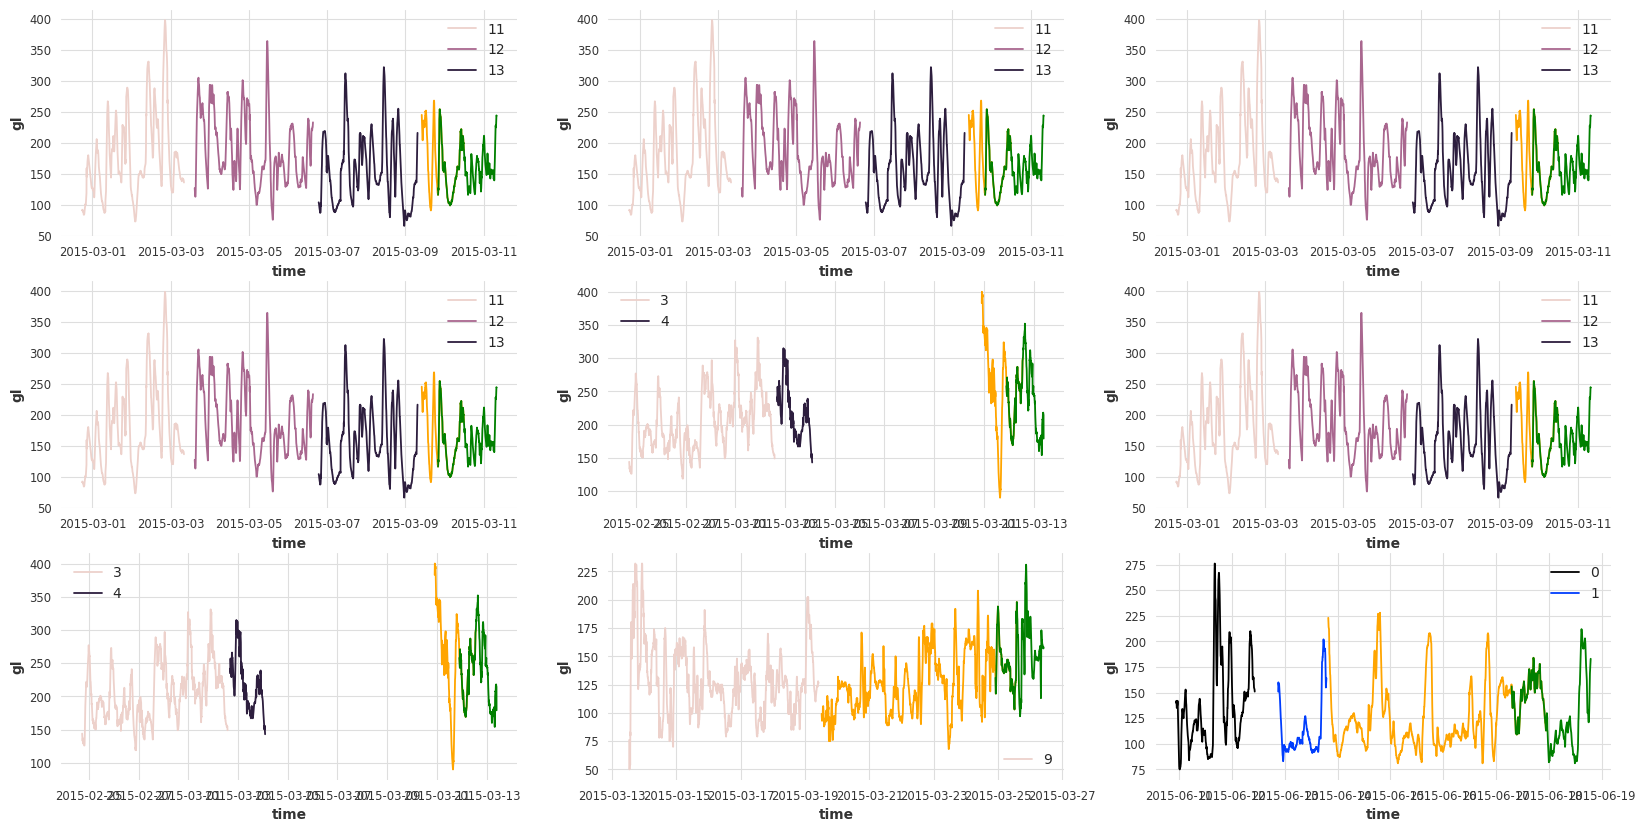

In [5]:
id = formatter.get_column('id')
time = formatter.get_column('time')
target = formatter.get_column('target')[0]
sid = formatter.get_column('sid')
# plot for 9 random ids
ids = np.random.choice(np.unique(formatter.train_data[id]), 9)
fig, axs = plt.subplots(3, 3, figsize=(20, 10))
for j, i in enumerate(ids):
    train_data = formatter.train_data[formatter.train_data[id] == i]
    val_data = None; test_data = None
    # check that i is an id in the validation data
    if i in np.unique(formatter.val_data[id]):
        val_data = formatter.val_data[formatter.val_data[id] == i]
    # check that i is an id in the test data
    if i in np.unique(formatter.test_data[id]):
        test_data = formatter.test_data[formatter.test_data[id] == i]
    # plot the data using seaborn
    sns.lineplot(x = time, y = target, data = train_data, hue=sid, ax=axs[j // 3, j % 3])
    if val_data is not None:
        sns.lineplot(x = time, y = target, data = val_data, color='orange', ax=axs[j // 3, j % 3])
    if test_data is not None:
        sns.lineplot(x = time, y = target, data = test_data, color='green', ax=axs[j // 3, j % 3])



In [ ]:
static_cols = formatter.get_column('static_covs')
static_cols = static_cols + [formatter.get_column('id')] if static_cols is not None else [formatter.get_column('id')]
dynamic_cols = formatter.get_column('dynamic_covs')
future_cols = formatter.get_column('future_covs')
# convert None to empty list
static_cols = [] if static_cols is None else static_cols
dynamic_cols = [] if dynamic_cols is None else dynamic_cols
future_cols = [] if future_cols is None else future_cols
# concatenate all covariates
covs = static_cols + dynamic_cols + future_cols

train_data = formatter.train_data
test_data = formatter.test_data.loc[~formatter.test_data.index.isin(formatter.test_idx_ood)]
test_data_ood = formatter.test_data.loc[formatter.test_data.index.isin(formatter.test_idx_ood)]

# plot histograms and densities of covariates using seaborn
fig, axs = plt.subplots(len(covs) // 3 + 1, 3, figsize=(10, 45))
for i, c in enumerate(covs):
    # create a dataframe with covariate and type
    df = pd.DataFrame({'covariate': train_data[c].values, 'type': 'train'})
    df2 = pd.DataFrame({'covariate': test_data[c].values, 'type': 'test'})
    df3 = pd.DataFrame({'covariate': test_data_ood[c].values, 'type': 'test_ood'})
    df = pd.concat([df, df2, df3])
    # plot density
    sns.histplot(data=df, 
                 x='covariate', 
                 hue='type', 
                 ax=axs[i // 3, i % 3], 
                 stat='density', 
                 common_norm=False, 
                 common_bins=True,
                 multiple='fill')
    axs[i // 3, i % 3].set_title(c)
plt.tight_layout()


## Linear Regression

In [ ]:
for i in range(len(series['train']['target'])):
    assert len(series['train']['future'][i]) == len(series['train']['target'][i])

In [ ]:
model = models.LinearRegressionModel(lags = 192,
                                     lags_future_covariates = (192, 12),
                                     output_chunk_length = formatter.params['length_pred'])

model.fit(series['train']['target'],
          future_covariates=series['train']['future'],
          max_samples_per_ts=100)

In [ ]:
forecasts = model.historical_forecasts(series['test']['target'],
                                        future_covariates=series['test']['future'],
                                        forecast_horizon=formatter.params['length_pred'], 
                                        stride=formatter.params['length_pred'] // 2,
                                        retrain=False,
                                        verbose=True,
                                        last_points_only=False,
                                        start=formatter.params['max_length_input'])
id_errors_sample = rescale_and_backtest(series['test']['target'],
                                    forecasts,  
                                    [metrics.mse, metrics.mae],
                                    scalers['target'],
                                    reduction=None)
id_errors_sample = np.vstack(id_errors_sample)
np.median(id_errors_sample, axis=0)

In [ ]:
forecasts = model.historical_forecasts(series['test_ood']['target'],
                                        future_covariates=series['test_ood']['future'],
                                        forecast_horizon=formatter.params['length_pred'], 
                                        stride=formatter.params['length_pred'] // 2,
                                        retrain=False,
                                        verbose=True,
                                        last_points_only=False,
                                        start=formatter.params["max_length_input"])
ood_errors_sample = rescale_and_backtest(series['test_ood']['target'],
                            forecasts,  
                            [metrics.mse, metrics.mae],
                            scalers['target'],
                            reduction=None)
ood_errors_sample = np.vstack(ood_errors_sample)
np.median(ood_errors_sample, axis=0)

In [ ]:
fig, axs = plt.subplots(5, 6, figsize=(50, 20))
for i in range(6):
    for j, f in enumerate(forecasts[i][:5]):
        f.plot(ax=axs[j, i], label='forecast')
        series['val']['target'][i].slice_n_points_after(f.time_index[0] - pd.Timedelta("2h"), 36).plot(ax=axs[j, i], label='true')
        axs[j, i].legend(fontsize=14)

## XGBoost

In [ ]:
model = models.XGBModel(lags=96, 
                        lags_future_covariates=(96, 12),
                        learning_rate=0.773,
                        subsample=0.8,
                        min_child_weight=1.0,
                        colsample_bytree=1.0,
                        max_depth=6,
                        gamma=0.5,
                        reg_alpha=0.167,
                        reg_lambda=0.229,
                        n_estimators=352,
                        model_seed=0)

model.fit(series['train']['target'],
          future_covariates=series['train']['future'],
          max_samples_per_ts=None, 
          )

In [ ]:
forecasts = model.historical_forecasts(series['test']['target'],
                                        future_covariates=series['test']['future'],
                                        forecast_horizon=formatter.params['length_pred'], 
                                        stride=formatter.params['length_pred'] // 2,
                                        retrain=False,
                                        verbose=True,
                                        last_points_only=False,
                                        start=formatter.params['max_length_input'])
id_errors_sample = rescale_and_backtest(series['test']['target'],
                                        forecasts,  
                                        [metrics.mse, metrics.mae],
                                        scalers['target'],
                                        reduction=None)
id_errors_sample = np.vstack(id_errors_sample)
np.median(id_errors_sample, axis=0)

In [ ]:
forecasts = model.historical_forecasts(series['test_ood']['target'],
                                        future_covariates=series['test_ood']['future'],
                                        forecast_horizon=formatter.params['length_pred'], 
                                        stride=formatter.params['length_pred'] // 2,
                                        retrain=False,
                                        verbose=True,
                                        last_points_only=False,
                                        start=formatter.params["max_length_input"])
ood_errors_sample = rescale_and_backtest(series['test_ood']['target'],
                            forecasts,  
                            [metrics.mse, metrics.mae],
                            scalers['target'],
                            reduction=None)
ood_errors_sample = np.vstack(ood_errors_sample)
np.median(ood_errors_sample, axis=0)

## TFT

In [ ]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

model_name = f'tensorboard_tft_covariates_weinstock'
work_dir = './output'
el_stopper = EarlyStopping(
                            monitor="val_loss",
                            patience=20,
                            min_delta=0.001,
                            mode='min',
                            )
loss_logger = LossLogger()
pl_trainer_kwargs = {"accelerator": "gpu", "devices": [0], "callbacks": [el_stopper, loss_logger]}

# build the TFTModel model
model = models.TFTModel(input_chunk_length = 96, 
                        output_chunk_length = formatter.params['length_pred'], 
                        hidden_size = 64,
                        lstm_layers = 1,
                        num_attention_heads = 4,
                        full_attention = True,
                        dropout = 0.1,
                        hidden_continuous_size = 16,
                        add_relative_index = True,
                        model_name = model_name,
                        work_dir = work_dir,
                        log_tensorboard = True,
                        pl_trainer_kwargs = pl_trainer_kwargs,
                        batch_size = 64,
                        optimizer_kwargs = {'lr': 0.001},
                        save_checkpoints = True,
                        force_reset=True)

In [ ]:
model.fit(series=series['train']['target'],
          future_covariates=series['train']['future'],
          val_series=series['val']['target'],
          val_future_covariates=series['val']['future'],
          max_samples_per_ts=200,
          verbose=True,)

In [ ]:
model.load_from_checkpoint(model_name, work_dir = work_dir)

forecasts = model.historical_forecasts(series['test']['target'],
                                        future_covariates=series['test']['future'],
                                        forecast_horizon=formatter.params['length_pred'], 
                                        stride=formatter.params['length_pred'] // 2,
                                        retrain=False,
                                        verbose=True,
                                        last_points_only=False,
                                        start=formatter.params['max_length_input'])
id_errors_sample = rescale_and_backtest(series['test']['target'],
                                        forecasts,  
                                        [metrics.mse, metrics.mae],
                                        scalers['target'],
                                        reduction=None)
id_errors_sample = np.vstack(id_errors_sample)
np.median(id_errors_sample, axis=0)